In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from library.Benchmark2 import *
import time
from library.Constant import *
from library.LogParser import *
from library.Result import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#50GB, 10GB overwrite
def test_data_disk_bulk_and_overwrite_with_compression(test_dir, num_keys = "125000000", 
                                                       num_keys_random = "25000000", run_random = True):
    rocks_db_dir = "/home/fxie/rocksdb"
    print(f"test dir {test_dir}")
    benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
    benchmark2.para_map["COMPRESSION_TYPE"] = "none"
    benchmark2.para_map["CACHE_SIZE"] = "104857600"
    benchmark2.para_map["NUM_KEYS"] = num_keys
    benchmark2.bulkload()
        
    #reduce kv num
    if run_random:
        benchmark2.para_map["NUM_KEYS"] = num_keys_random
        benchmark2.overwrite()

        benchmark2.readrandom()
        
    benchmark2.clean_up()   

In [52]:
def plot_bar(disk_names, results, y_label, title, color):
    y_pos = np.arange(len(disk_names))
    plt.bar(y_pos, results, align='center', alpha=0.5, width = 0.3, color = color)
    plt.xticks(y_pos, disk_names)
    plt.ylabel(y_label)
    plt.title(title)
    for i in range(len(results)):
        plt.text(x = y_pos[i] - 0.1 , y = results[i]+0.1, s = results[i], size = 10)
    plt.show()

In [55]:
def plot_benchmark(root_dir, disk_names, log_file_names, y_labels, color = 'r'):
    for y_label in y_labels:
        for test_file_name in log_file_names:
            results = []
            for disk_name in disk_names:
                parser = LogParser(file_name = f"{root_dir}/{disk_name}/output/{test_file_name}")
                result = Result()
                parser.parse_all(result)
                results.append(result.res_map[y_label])
            print(results)
            plot_bar(disk_names, results, y_label, f"{test_file_name} | {y_label}", color)

In [5]:
#compare local disk vs data disk read cache vs data disk readwrite cache
log_file_names = ["benchmark_bulkload_fillrandom.log", "benchmark_overwrite.t1.s0.log", "benchmark_readrandom.t1.log"]
disk_names = ["local_disk", "no_cache", "read_cache", "readwrite_cache"]
root_dir = "/home/fxie/samza-azure-storage/milestone2/results/rocks_db_benchmark_results5"

[362.5, 112.3, 66.8]


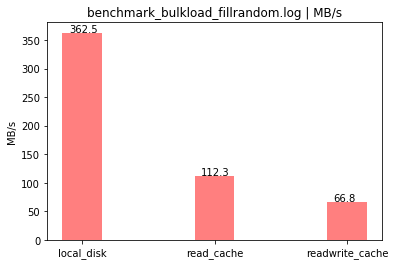

[142.2, 48.5, 29.0]


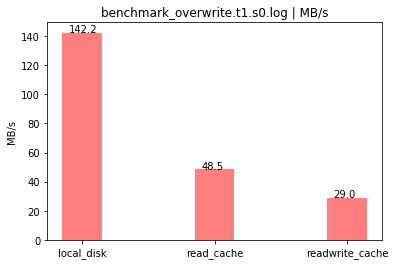

[33.8, 16.7, 15.7]


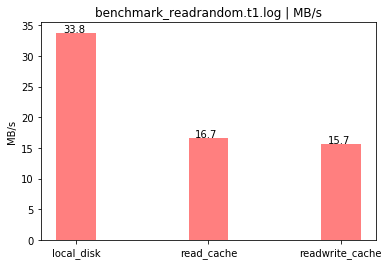

In [57]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_THROUGHPUT], 'r')

[1.78, 2.6, 3.53]


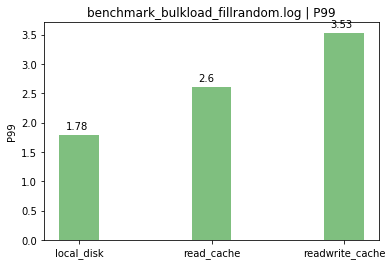

[5.96, 13.97, 19.97]


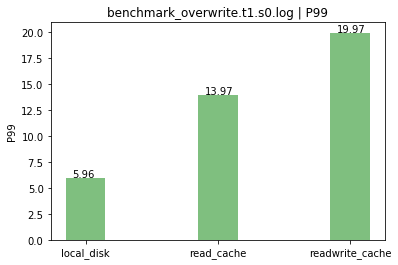

[33.2, 347.47, 352.23]


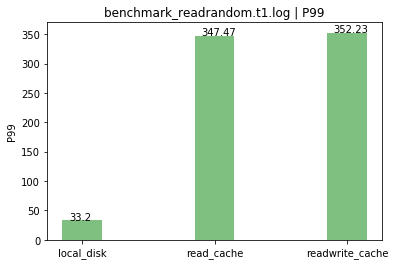

In [58]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_P99], 'g')

[0.51, 0.52, 0.52]


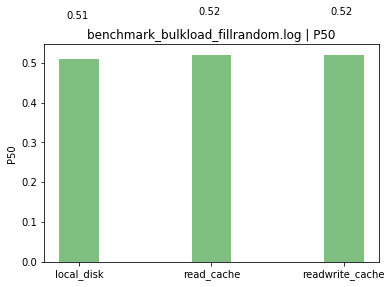

[1.61, 1.92, 1.94]


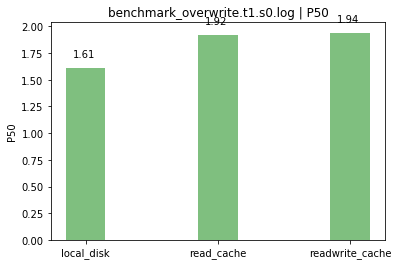

[8.85, 8.13, 8.23]


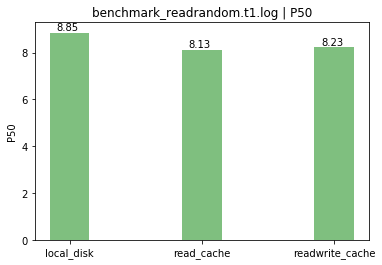

In [64]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_P50], 'g')

In [61]:
#test warm-up latency
log_file_names2 = [ "benchmark_overwrite.t1.s0.log"]
disk_names2 = ["read_cache", "warm_up_latency_after_mount_movement", "warm_up_latency_after_clone"]

[48.5, 42.4, 47.7]


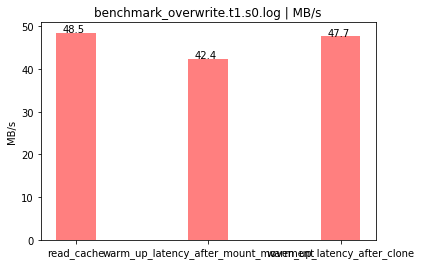

In [62]:
plot_benchmark(root_dir, disk_names2, log_file_names2, [LOG_RES_THROUGHPUT], 'r')

[13.97, 11.83, 11.06]


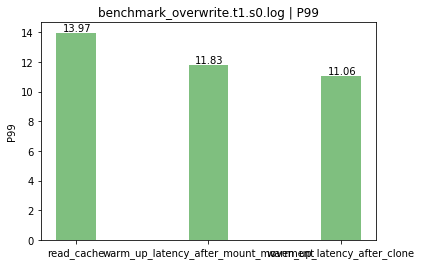

In [63]:
plot_benchmark(root_dir, disk_names2, log_file_names2, [LOG_RES_P99], 'g')

In [8]:
#for test_dir in ["/read_cache2", "/readwrite_cache", "/read_cache"]:
    #test_data_disk_bulk_and_overwrite_with_compression(test_dir)

In [7]:
#for test_dir in ["/read_cache3", "/read_cache4"]:
    #test_data_disk_bulk_and_overwrite_with_compression(test_dir, False)

In [6]:
#local disk
#test_data_disk_bulk_and_overwrite_with_compression("/mnt")

In [4]:
#no cache
test_data_disk_bulk_and_overwrite_with_compression("/no_cache")

test dir /no_cache
Setup a new test root. Test root dir /no_cache/test-439815266
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/no_cache/test-439815266/db OUTPUT_DIR=/no_cache/test-439815266/output WAL_DIR=/no_cache/test-439815266/wal TEMP=/no_cache/test-439815266/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-02 20:52:34.390918
===== Benchmark =====
Start bulkload at Fri Aug  2 20:52:34 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_byt

===== Benchmark =====
Start overwrite at Fri Aug  2 21:11:18 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=134217728 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=ski

===== Benchmark =====
Start readrandom at Fri Aug  2 21:14:55 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=134217728 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip_list 